In [149]:
import numpy as np
import pandas as pd

from scipy.stats import f_oneway, mannwhitneyu, pearsonr

import matplotlib.pyplot as plt
import seaborn as sns

from toolbox_ML import describe_df, tipifica_variables, categoriza_variables, check_parametros, get_features_cat_regression,get_features_num_regression, plot_features_cat_regression, \
    plot_features_num_regression,plot_target_vs_features

### 0. Introducción
- Para la demostración de nuestro módulo de funciones, vamos a utilizar el dataset de los pingüinos de la librería seaborn. 
- Las funciones están enfocadas al entrenamiento de un modelo de Regresión Lineal.
- Nuestra variable target será 'body_mass_g', ya que el hipotético modelo tendrá que predecir el peso corporal de los pingüinos en función de ciertos atributos o features.

In [150]:
# Cargamos el dataset de los pingüinos de la librería seaborn

df_penguins = sns.load_dataset('penguins')
df_penguins.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female


In [151]:
# El datset contiene tanto variables categóricas como numéricas.
# Además, observamos que contiene nulos.

df_penguins.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            344 non-null    object 
 1   island             344 non-null    object 
 2   bill_length_mm     342 non-null    float64
 3   bill_depth_mm      342 non-null    float64
 4   flipper_length_mm  342 non-null    float64
 5   body_mass_g        342 non-null    float64
 6   sex                333 non-null    object 
dtypes: float64(4), object(3)
memory usage: 18.9+ KB


In [152]:
# Para esta demostración en concreto, vamos a desechar todos los nulos. Ante un problema real de regresión lineal, veríamos como tratar estos datos.

df_penguins = df_penguins.dropna()

In [153]:
# Instanciamos el target

target = 'body_mass_g'

### 1. Describe_df()

Esta función devuelve un dataframe con breve resumen de la info más relevante del conjunto de datos sin que tengamos que analizarlos en profundidad. Obtenemos el tipo de variable (en términos de pandas), % de valores nulos, nº de valores únicos de cada variable y % cardinalidad.

In [154]:
describe_df(df_penguins)

,COL_N,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
,DATA_TYPE,object,object,float64,float64,float64,float64,object
,MISSINGS (%),0.0,0.0,0.0,0.0,0.0,0.0,0.0
,UNIQUE_VALUES,3,3,163,79,54,93,2
,CARDIN (%),0.9,0.9,48.95,23.72,16.22,27.93,0.6


### 2. Tipifica_variables()

Esta función clasifica las variables del dataset teniendo en cuenta los valores únicos de cada una de ellas, así como los umbrales de categoría y de numérica continua que escojamos. Podemos modificar los umbrales en función de lo que necesite nuestro dataset.

In [155]:
df_tipificado = tipifica_variables(df_penguins, 6, 15)
df_tipificado

,nombre_variable,tipo_sugerido
0,species,Categórica
1,island,Categórica
2,bill_length_mm,Numérica continua
3,bill_depth_mm,Numérica continua
4,flipper_length_mm,Numérica continua
5,body_mass_g,Numérica continua
6,sex,Binaria


Instanciamos el resultado de la función para crearnos dos listas que distingan entre categóricas y numéricas y las guardamos para utilizarlas más adelante. Para dataframes con un gran número de variables, esto nos facilitará mucho el trabajo.

In [156]:
es_catego = df_tipificado.tipo_sugerido == "Categórica"
es_binaria = df_tipificado.tipo_sugerido == "Binaria"

lista_categoricas = df_tipificado.loc[es_catego | es_binaria]['nombre_variable'].to_list()

num_dis = df_tipificado.tipo_sugerido == "Numérica discreta"
num_con = df_tipificado.tipo_sugerido == "Numérica continua"

lista_numericas = df_tipificado.loc[num_dis | num_con]['nombre_variable'].to_list()

print(f"Lista categóricas: {lista_categoricas}")
print(f"Lista numéricas: {lista_numericas}")

Lista categóricas: ['species', 'island', 'sex']
Lista numéricas: ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']


Por último, 'categoriza_variables' fusiona las los anteriores y nos devuelve los resultados unificados en un único dataframe. 

In [157]:
categoriza_variables(df_penguins, 10, 20)

,Features,Data_type,%_Missings,Unique_values,%-Cardinalidad,Tipo_sugerido
0,species,object,0.0,3.0,0.90,Categórica
1,island,object,0.0,3.0,0.90,Categórica
2,bill_length_mm,float64,0.0,163.0,48.95,Numérica continua
3,bill_depth_mm,float64,0.0,79.0,23.72,Numérica continua
4,flipper_length_mm,float64,0.0,54.0,16.22,Numérica discreta
5,body_mass_g,float64,0.0,93.0,27.93,Numérica continua
6,sex,object,0.0,2.0,0.60,Binaria


### 3. Get_features_num_regression()



La función 'get_features_num_regression' recorre todas las columnas numéricas de un dataframe y calcula su correlación con la columna target. Nos devolverá una lista con la selección de features numéricas con las que vamos a entrenar a nuestro hipotético modelo de regresión lineal. Veamos cómo se comporta en función de los valores de sus argumentos: 

In [158]:
# Con una correlación del 0.3, todas las variables numéricas aparecen en la lista.

print("Variables númericas con correlación > 0.3 y confianza estadística del 95%:")
get_features_num_regression(df_penguins, target, umbral_corr=0.3, pvalue=0.05)

Variables númericas con correlación > 0.3 y confianza estadística del 95%:


['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm']

In [159]:
# Al aumentar la correlación a un 0.5, vemos como ahora la lista de features disminuye

print("Variables númericas con correlación > 0.5 y confianza estadística del 95%:")
get_features_num_regression(df_penguins, target, umbral_corr=0.5, pvalue=0.05)

Variables númericas con correlación > 0.5 y confianza estadística del 95%:


['bill_length_mm', 'flipper_length_mm']

Además, esta función se encarga de verificar que los argumentos de entrada son válidos (tanto por el tipo, como el rango del valor). Para ello, invoca una segunda función auxiliar check_parametros. Veamos un ejemplo:

In [160]:
get_features_num_regression(df_penguins,target, umbral_corr=2)

Error: 'umbral_corr' debe estar entre 0 y 1.


### 4. Plot_features_num_regression()

Esta versión gráfica de 'get_features_num_regression' nos devuelve un pairplot del dataframe considerando target con todas aquellas variables numéricas correlacionadas según nuestro criterio. Gracias a su argumento 'columns', se puede usar contra todas las columnas del dataframe (por defecto con una lista vacía) o pasándole una lista de variables numéricas de nuestra elección.


- Si 'columns' contiene una lista vacía:

Devuelve un pairplot con aquellas variables numéricas del dataset que superen el umbral de correlación establecido en el argumento, así como el pvalue (confianza estadística). Veamos como devuelve gráficas distintas en función de los valores de los umbrales.

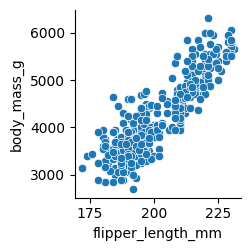

In [161]:
plot_features_num_regression(df_penguins, target_col=target, columns=[], umbral_corr=0.6, pvalue=0.05)  # corr 0.6

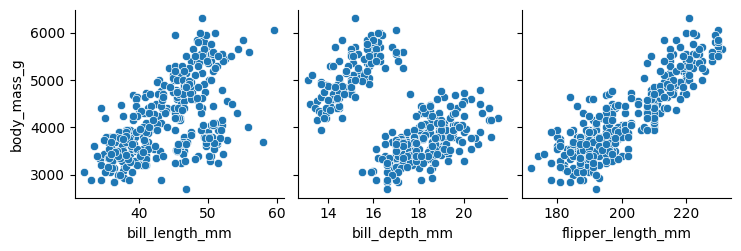

In [162]:
plot_features_num_regression(df_penguins, target_col=target, columns=[], umbral_corr=0.4, pvalue=0.01) # menor corr 0.4 mayor confianza estadística (pvalue 0.01)

- Si le pasamos una lista, calcula la correlación de  las variables de la lista y pinta las que superen el umbral establecido: 

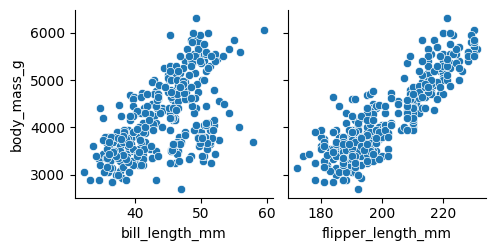

In [163]:
lista_numericas  # recuperamos la lista de numéricas que obtuvimos gracias a tipifica_variables y la pasamos como argumento

plot_features_num_regression(df_penguins, target_col=target, columns=lista_numericas, umbral_corr=0.5, pvalue=0.05)

### 5. Get_features_cat_regression()

Esta función recorre todas las columnas categóricas de un dataframe (llamando a tipifica_variable) y calcula su confianza estadística con respecto al target mediante los tests U de Mann-Whitney (binarias) o ANOVA (el resto). Nos devolverá una lista con la selección de features categóricas con las que vamos a entrenar a nuestro hipotético modelo de regresión lineal. Veamos cómo se comporta en función de los valores de sus argumentos: 

In [164]:
get_features_cat_regression(df_penguins, target, umbral_categoria= 4, pvalue=0.05) # como invoca tipifica_variable, comprarten los argumentos umbral_categoria y umbral_continua

['species', 'island', 'sex']

In [165]:
get_features_cat_regression(df_penguins, target, umbral_categoria= 3, pvalue=0.01) # al reducir uno de los umbrales y el pvalue, vemos que la selección de features se acota a uno

['sex']

Del mismo modo que get_features_num_regression, esta función también invoca a la auxiliar check_parametros para verificar sus argumentos. Veamos otro ejemplo: 

In [166]:
get_features_cat_regression(df_penguins, "sex")

Error: la columna 'sex' no es numérica.


### 6. Plot_features_cat_regression()


Esta versión gráfica de 'get_features_cat_regression' nos devuelve los histogramas agrupados de la variable target para cada uno de los calores de las variables categóricas. Gracias a su argumento 'columns', se puede usar contra todas las columnas del dataframe (por defecto con una lista vacía) o pasándole una lista de variables categóricas de nuestra elección.


- Si 'columns' contiene una lista vacía:

Devuelve un histplot con aquellas variables categóricas del dataset que superen el test pertinente (U de Mann-Whitney o ANOVA) con la confianza estadística establecida por el argumento p-value. Veamos como devuelve gráficas distintas en función de los valores de los umbrales.

In [ ]:
plot_features_cat_regression(df_penguins, target_col=target, columns=[], pvalue=0.05, with_individual_plot=False, escala_log=False)

- Si le pasamos una lista de categóricas, realiza los tests pertinentes invocando a get_features_cat y nos pinta sólo las que lo superen con la confianza estadística establecida en el argumento p-value. 

In [ ]:
lista_categoricas # nos traemos la lista de categóricas que obtuvimos de tipifica_variables

plot_features_cat_regression(df_penguins, target_col=target, columns=[], pvalue=0.03,  with_individual_plot=False, escala_log=False)

### 7. (EXTRA) Plot_target_vs_features()

Aprovechando las funciones de visualizaciñon que hemos creado, hemos implementado un scatter plot que además de mostrar el bivariante de cada numérica con el target, distingue por colores las categóricas. Esto nos ayuda a entender la diferencia de datos sobre todo en función de las especies y del sexo de los pingüinos. Lo ponemos como extra pues no lo podrías emplear en nuestro modelo de regresión linear, sino en uno de árboles de decisión.

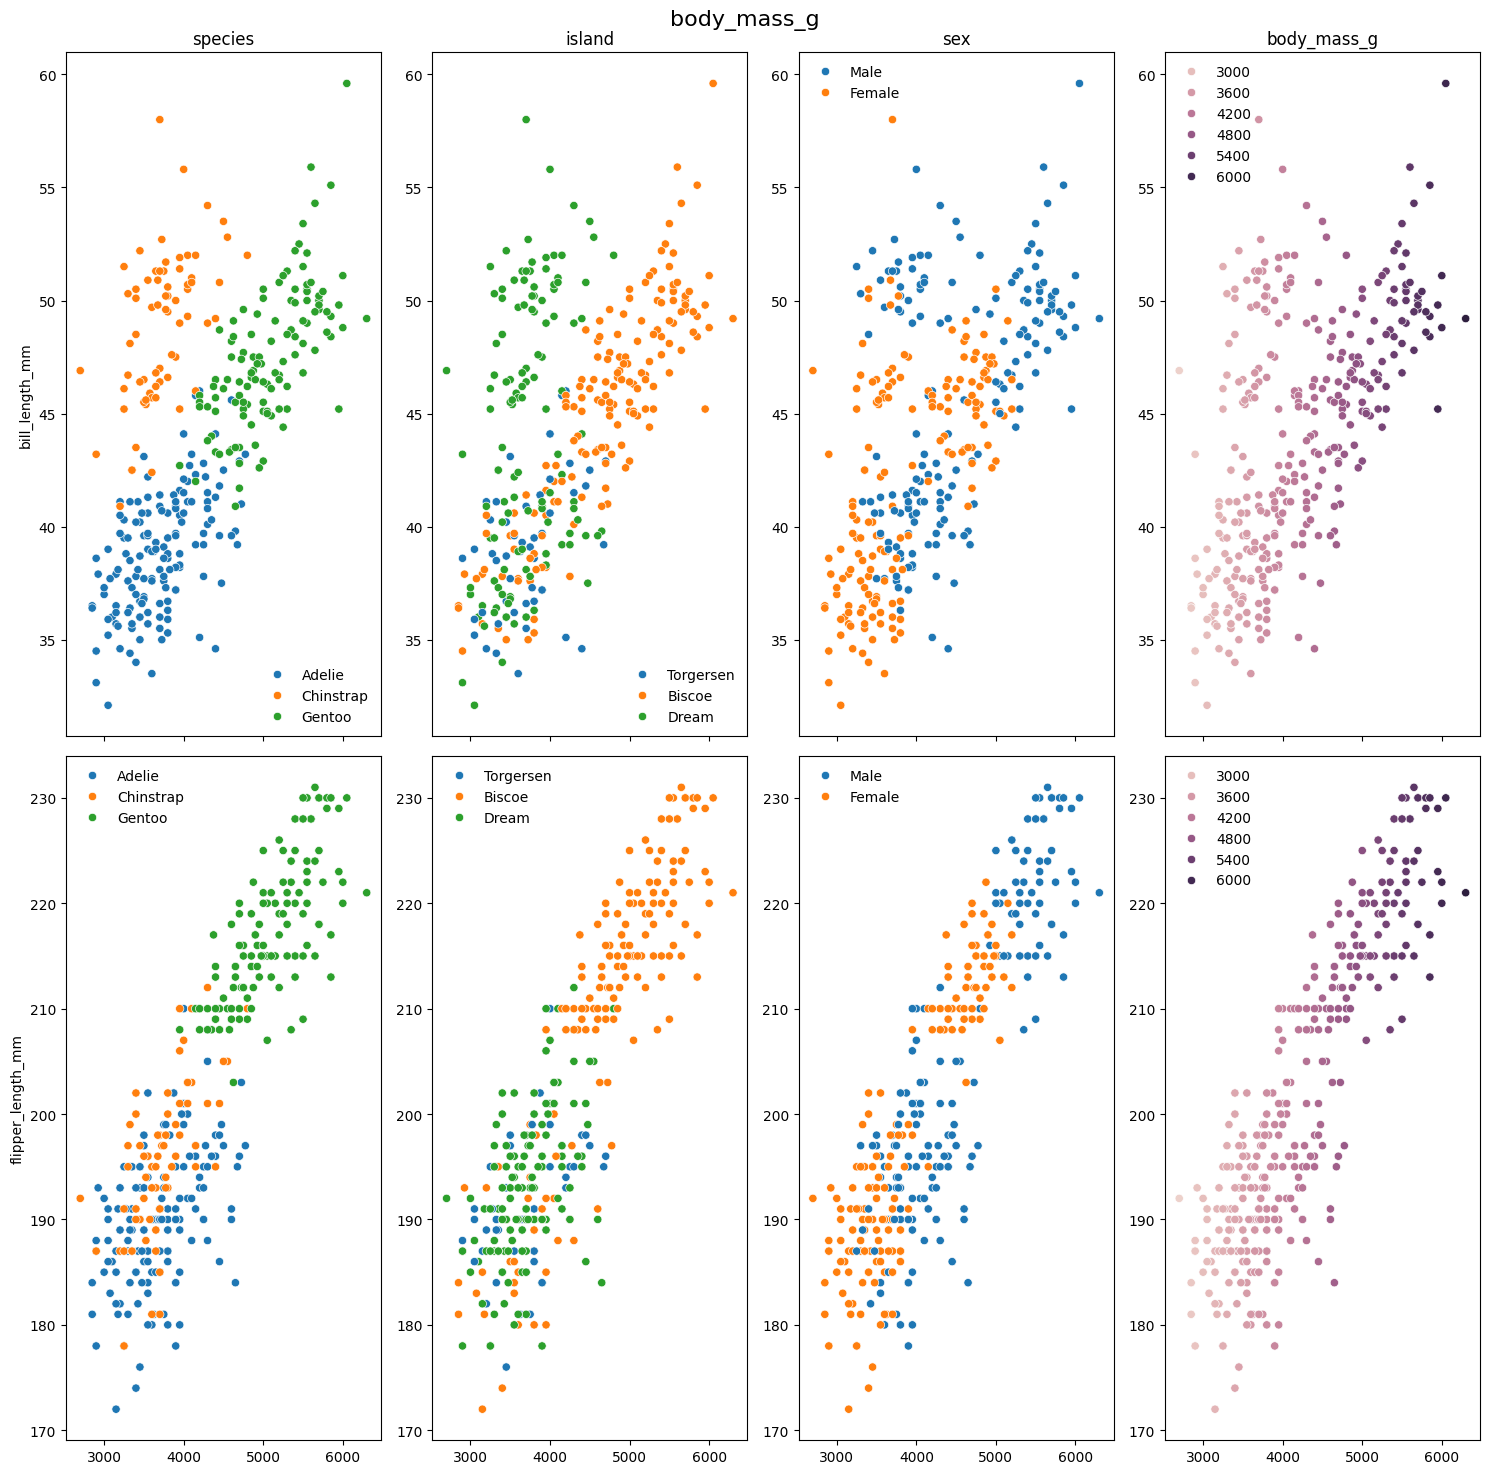

In [169]:
plot_target_vs_features(df_penguins, target, features_cat, features_num)